# Bandits for Recommendation - RLSS 2019

For conveniency slides used for presentation are available on https://www.dropbox.com/s/6px7a37qddstgtn/RLSS.pdf?dl=0

The objective of this notebook is to apply the bandits algorithms to recommendation problem using a simulated envrionment. Although in practice you would also use the real data, the complexity of the recommendation problem and the associated algorithmic challenges can already be revealed even in this simple setting.

![RecSys](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/recsys_scheme.png?raw=1)

## Controlled recommendation environment

In the simulated environment, user browsers a web-site and might click on recommendation served by a recommendation agent. The goal of the agent is to maximize the number of clicks. The simulation is going to be a little bit more involved that ideal situation from the previous TP. In particular we are going to work on a stream of user which are also generating some "organic" observations, meaning that you collect some browsing events and have to perform some recommendations until the user decides to leave.

### Define action, observation, reward

* Action -- a recommended item (e.g., in e-commerce it can be a product). Here the simulator will be set to have 100 possible products
* Reward -- user interaction with the recommendation (e.g., a click)
* Observation -- user activity (e.g., list of products that user has visited during his/her browsing session). Here we report only "organic" event which are not the recommended item and can occur even if the recommendation was not used.

In [1]:
# If you are running this notebook on Colab, setup with the following:
#!git clone https://github.com/yfletberliac/rlss2019-hands-on.git > /dev/null 2>&1
import sys
#sys.path.insert(0, './rlss2019-hands-on/utils/rec_systems')
# If using the notebook locally, replace by:
sys.path.insert(0, './bandits_reco_class_sujet')

In [2]:
from reco_env import RecoEnv, env_1_args
from configuration import Configuration
from agent import Agent, RandomAgent, random_args

# you can overwrite environment arguments here
RND_SEED = 1234
env_1_args['random_seed'] = RND_SEED

# create environment with configuration
env = RecoEnv(Configuration({
            **env_1_args,
}))
env.reset()

# random agent
rand_agent = RandomAgent(Configuration({
    **random_args,    
}))

# counting steps
i = 0

observation, _, _, _ = env.step(None)
reward, done = 0, False
while not done:
    # choose action given current observation
    action = rand_agent.act(observation)            
    # execute action in the environment
    observation, reward, done, info = env.step(action['a'])
    print(f"Step: {i} - Action: {action} - Observation: {observation} - Reward: {reward}")
    i += 1

Step: 0 - Action: {'a': 66, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 1 - Action: {'a': 92, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 2 - Action: {'a': 98, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 3 - Action: {'a': 17, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 4 - Action: {'a': 83, 'ps': 0.01} - Observation: [72, 27, 27, 12] - Reward: 0
Step: 5 - Action: {'a': 57, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 6 - Action: {'a': 86, 'ps': 0.01} - Observation: [] - Reward: 0
Step: 7 - Action: {'a': 97, 'ps': 0.01} - Observation: [] - Reward: 0


### Simulation of user response to recommendation

User response to recommendation is modeled as a function of (1) affinity of user to recommended product, and (2) correction due to the recommendation. 

$\mu(u,p,t) := f(\Lambda(u,p,t) + \epsilon(u,p,t))$,

where $f$ is an increasing function, $\Lambda(u,p,t)$ is the log odds of user $u$ being interested by product $a$ at time $t$, $\epsilon(u,p,t))$ is a zero mean correction.

Assuming the latent space for user and product, let $\omega \in \mathbb{R}^K$ be the latent representation of user $u$ of size $K$, $\beta \in \mathbb{R}^K$ is the latent reprentation of product $p$, then user response on recommendation can be modeled as

$\mu(u,p,t) := \text{sigmoid}(\beta^T \omega + \mu_\epsilon)$, 

where $\omega_i = \mathcal{N}(0, \sigma^2_\omega)$, $\beta_i = \mathcal{N}(0, 1)$, $\mu_\epsilon = \mathcal{N}(0, \sigma^2_\mu)$.

In advertisement, typical values for $\mu(u,p,t)$ are around $0.02$.

## Online learning using recommendation environment

We introduce functions that train, evaluate and plot the evaluation metrics of recommendation agents.

In [3]:
from train_eval_utils import train_eval_agents, plot_ctr

help(train_eval_agents)
help(plot_ctr)

Help on function train_eval_agents in module train_eval_utils:

train_eval_agents(agents, config, num_train_users, num_eval_users)
    Trains and evaluates a list of agents on a given number of users
    
    :param agents: list of agents to evaluate
    :param config: configuration of recommendation environment
    :param num_train_users: number of train users
    :param num_eval_users: number of evaluation users
    :return dataframe containing agent class, 50% quantile of CTR, 2.5% quantile of CTR, 97.5% quantile of CTR, execution time

Help on function plot_ctr in module train_eval_utils:

plot_ctr(eval_ctr)
    Plots agents average CTR and confidence interval
    
    :param eval_ctr: dataframe containing agent class, 50% quantile of CTR, 2.5% quantile of CTR, 97.5% quantile of CTR



## Bandits

Code bandits algorithms that you have already seen in the class. In this part the simulator is configured in a such way that we are actually facing the stochastic bandit setting: all the users are the same and their preferences are not evolving.

### UCB algorithm [Auer 2002]

Code the agent that runs the UCB algorithm for product click-through rate (number of clicks / number of displays).

* First, we provide the code for bound based on Hoeffding inequality

$I_k = argmax_k \hat{\mu}_{k,n} + \sqrt{\frac{2 \log t}{n}}$


* Then, improve by tuning $\alpha$ 

$I_k = argmax_k \hat{\mu}_{k,n} + \alpha \sqrt{\frac{2 \log t}{n}}$

* Finally, use the fact that click is a Bernoulli random variable to obtain a sharper bound

In [9]:
import numpy as np

# Implement an Agent interface
class AlphaUCBAgent(Agent):
    def __init__(self, config):
        super(AlphaUCBAgent, self).__init__(config)

        # Init with ones to avoid division by zero
        self.product_rewards = np.zeros(self.config.num_products, dtype=np.float32)
        self.product_counts = np.ones(self.config.num_products, dtype=np.float32)       
        # alpha parameter (already tuned)
        self.alpha = 0.01        
        
    def train(self, observation, action, reward, done):
        """Train from observed data"""

        if reward is not None and action is not None:
            self.product_rewards[action] += reward
            self.product_counts[action] += 1

    def act(self, observation):
        """Return an action given current observation"""
        
        t = sum(self.product_counts)
        ucb = self.product_rewards / t + self.alpha * np.sqrt(2.0*np.log(t)/self.product_counts)
        action = np.argmax(ucb)

        return { 'a': action }

In [14]:
from scipy.stats.distributions import beta

def ucb_bound(num_clicks, num_displays):
    q = .99
    return beta.ppf(q, num_clicks, num_displays)

class BetaUCBAgent(Agent):
    def __init__(self, config):
        super(BetaUCBAgent, self).__init__(config)

        self.product_rewards = np.zeros(self.config.num_products, dtype=np.float32)
        self.product_counts = np.ones(self.config.num_products, dtype=np.float32)
        
        self.ucb_func = np.vectorize(ucb_bound)
        
    def train(self, observation, action, reward, done):
        if reward is not None and action is not None:
            self.product_rewards[action] += reward
            self.product_counts[action] += 1

    def act(self, observation):
        ucb = self.ucb_func(self.product_rewards, self.product_counts)
        action = np.argmax(ucb)

        return { 'a': action }

### Compare UCB agents performance and running time in stochastic bandits setting

* Train and evaluate UCB with Hoeffding bound and exact bound

* Achieve similar performance by tuning $\alpha$ parameter

* Compare the running time

           Agent     0.500     0.025     0.975        Time
0    RandomAgent  0.095866  0.093602  0.098162    9.450065
1  AlphaUCBAgent  0.347528  0.343176  0.351897   10.576081
2   BetaUCBAgent  0.344715  0.340384  0.349062  106.047986


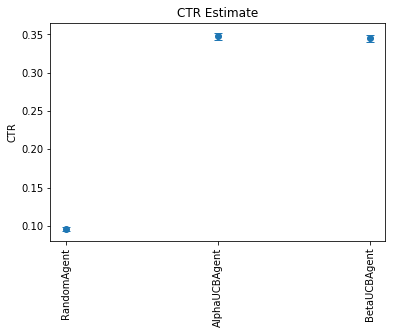

In [15]:
# number of products to recommend
num_products = 10
# number of users for train and evaluation
num_train_users, num_eval_users = 1000, 1000

custom_args = { 'num_products': num_products,
                'random_seed': RND_SEED,
              }
config = Configuration({ 
        **env_1_args,
        **custom_args,
})

alpha_ucb_agent = AlphaUCBAgent(config)
beta_ucb_agent = BetaUCBAgent(config)
rand_agent = RandomAgent(config)

agents = [rand_agent, alpha_ucb_agent, beta_ucb_agent]

stats = train_eval_agents(agents, config, num_train_users, num_eval_users)
print(stats)

plot_ctr(stats)

### Exp3 / Boltzmann exploration algorithm

* Code the agent that runs the Exp3 / Boltzmann exploration algorithm. The adversarial setting is going to be described later in the course but you can find it on wikipedia https://en.wikipedia.org/wiki/Multi-armed_bandit#Exp3[43].
__Remark:__ *it is possible to have a exponential speedup of the sampling unsing storing the weights in a binary tree containing partial sums, see http://timvieira.github.io/blog/post/2016/11/21/heaps-for-incremental-computation/*

* Tune temperature parameter

In [69]:
from scipy.special import logsumexp
from numpy.random import choice

class Exp3Agent(Agent):
    def __init__(self, config):
        super(Exp3Agent, self).__init__(config)

        self.product_rewards = np.zeros(self.config.num_products, dtype=np.float32)    
        self.product_counts = np.ones(self.config.num_products, dtype=np.float32)
        self.gamma = 100
        self.omega = np.ones(self.config.num_products)
        self.K = self.config.num_products
        self.t = 1
        
    def train(self, observation, action, reward, done):
        if reward is not None and action is not None:
            self.product_rewards[action] += reward
            self.product_counts[action] += 1
            a = action
            prob = self.softmax(self.product_rewards/self.product_counts*(1-self.gamma))        
            p = prob[a]
         
        self.t += 1
    
    def log_softmax(self, vec):
        return vec - logsumexp(vec)

    def softmax(self, vec):
        probs = np.exp(self.log_softmax(vec))
        probs /= probs.sum()
        return probs
    
    def act(self, observation):
        # compute probability of choosing action using Boltzmann exploration
        prob = self.softmax(self.product_rewards/self.product_counts*self.gamma)        
     
        # sample an action
        action = np.random.choice(np.arange(self.K), p=prob)
        
#         observation = np.asarray(observation)
#         for k in range(self.K):
#             x_ = int(np.any(observation==k))/prob[k]
#             self.omega[k] = self.omega[k]*np.exp(self.gamma*x_/self.K)
        
        return { 'a': action, 'ps': prob[action] }

### Compare UCB and Exp3 agents performance and running time in stochastic bandits setting

* Train and evaluate UCB and Exp3 algorithms against random product recommendation

* Increase the number of products to 100 and explain the change

           Agent     0.500     0.025     0.975       Time
0    RandomAgent  0.095866  0.093602  0.098162   8.265573
1  AlphaUCBAgent  0.347528  0.343176  0.351897  11.987604
2      Exp3Agent  0.347528  0.343176  0.351897  14.982127


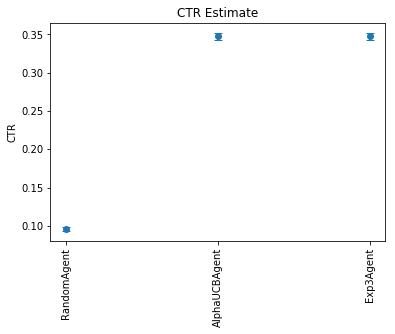

In [70]:
# number of products to recommend
num_products = 10
# number of users for train and evaluation
num_train_users, num_eval_users = 1000, 1000

custom_args = { 'num_products': num_products,
                'random_seed': RND_SEED,
              }
config = Configuration({ 
        **env_1_args,
        **custom_args,
})

ucb_agent = AlphaUCBAgent(config)
exp3_agent = Exp3Agent(config)
rand_agent = RandomAgent(config)

agents = [rand_agent, ucb_agent, exp3_agent]

stats = train_eval_agents(agents, config, num_train_users, num_eval_users)
print(stats)

plot_ctr(stats)

### Compare UCB and Exp3 agents in a non-stationary setting

Now we set the simulation to have some updates in the preference of the users thought they are initialized equally (using the random_seed given in the custom_args). This modelization of the user state change leads to non-stationary user response to a recommendation and is dependant of what you recommended.

In [ ]:
num_products = 100
num_train_users, num_eval_users = 1000, 1000

# adversarial setting: increase user state change during time
custom_args = { 'num_products': num_products,
                'random_seed': RND_SEED,                
                'sigma_omega': 0.3
              }
config = Configuration({ 
        **env_1_args,
        **custom_args,
})

ucb_agent = AlphaUCBAgent(config)
exp3_agent = Exp3Agent(config)
rand_agent = RandomAgent(config)

agents = [rand_agent, ucb_agent, exp3_agent]

stats = train_eval_agents(agents, config, num_train_users, num_eval_users)
print(stats)

plot_ctr(stats)

## Compare sample complexity

$\sigma$-subgaussian distribution
* UCB
$R_T = \mathcal{O}(\sum_{i>1} \frac{\log T}{\Delta_i})$
* Exp3
$R_T = \mathcal{O}(\sum_{i>1}\frac{\log^2 (T \Delta_i^2)}{\Delta_i})$

distribution-independent
* UCB
$R_T = \mathcal{O}(\sqrt{KT\log T})$
* Exp3
$R_T = \mathcal{O}(\sqrt{KT}\log K)$

## Using side data: browsing events

To make algorithms more sample efficient, we will use side data to bootstrap the recommendation. Specifically, we will use the user browsing events (aka "organic" events). The amount of browsing data is typically much larger than the number of click events on recommendation.

### Popularity agent

The simpliest recommedation agent is based on the total number of views of the product during browsing.

In [0]:
class PopularityAgent(Agent):
    def __init__(self, config):
        super(PopularityAgent, self).__init__(config)

        # Track number of times each item is viewed during browsing
        self.nb_views = np.ones(self.config.num_products)

    def train(self, observation, action, reward, done):
        if observation:
            for view in observation:
                self.nb_views[view] += 1
    def act(self, observation):
        # compute probability of choosing an action proportionally to the total number of views
        prob = self.nb_views/np.sum(self.nb_views)
        # choose action
        action = np.random.choice(np.arange(self.K), prob)
        
        return { 'a': action, 'ps': prob[action] }

### Contextual Bandit

Improve the popularity agent by personalizing popularity to the user interest. We represent the user interest by the last product he/she has seen. 

In [0]:
from scipy.special import logsumexp

class ContextualExp3Agent(Agent):
    def __init__(self, config):
        super(ContextualExp3Agent, self).__init__(config)

        self.product_rewards = np.zeros((self.config.num_products, self.config.num_products))
        self.last_product_seen = None
        # softmax temperature parameter
        self.eta = 0.01
                
    def update_lps(self, observation):
        """Update the last product seen based on the current observation"""
        if observation:
            self.last_product_seen = observation[-1]
            
    def train(self, observation, action, reward, done):
        if observation:
            # TODO: code the update for product_rewards matrix
            ..
            
    def log_softmax(self, vec):
        return vec - logsumexp(vec)

    def softmax(self, vec):
        probs = np.exp(self.log_softmax(vec))
        probs /= probs.sum()
        return probs
    
    def act(self, observation):
        self.update_lps(observation)
        
        # TODO: compute probability of choosing an action given last seen product by the user
        prob = ..
        # TODO: choose action
        action = ..

        return { 'a': action, 'ps': prob[action] }

### Compare agents that use click events to agents that use view events

In [0]:
num_products = 100
num_train_users, num_eval_users = 1000, 1000

# increase difference among users
custom_args = { 'num_products': num_products,
                'random_seed': RND_SEED,
                'sigma_omega_initial': 2.0,                
              }
config = Configuration({ 
        **env_1_args,
        **custom_args,
})

contextual_exp3_agent = ContextualExp3Agent(config)
exp3_agent = Exp3Agent(config)
pop_agent = PopularityAgent(config)
ucb_agent = AlphaUCBAgent(config)
rand_agent = RandomAgent(config)

agents = [pop_agent, contextual_exp3_agent, exp3_agent, ucb_agent, rand_agent]

stats = train_eval_agents(agents, config, num_train_users, num_eval_users)
print(stats)

plot_ctr(stats)

## Offline evaluation

Running counterfactual evaluations on real datasets use more time than a reasonnable practical sessions does. 
We are going to exhibit the core of the problems theses algorithms faces on a very toy example. 

Assume we are running a $\pi_0$ policy random uniform on the possible sets of arms of size 20 with a number of context 10. This means that at each timestep we have 200 possibles combinations to create the recommendation which is very small. Moreover we assume that the obtained reward is a constant equal to 1. This means we have no stochasticity due to realization of the sample and any policy $\pi$ should have the same estimator of averaged reward.

1. We assume the new $\pi$ is always choosing arm 1, plot the estimation of the IPS  with respect to the number of samples on one run. If you want to be close to the reality (and do more sophisticated experiments), it is better to simulate a dataset $S=\{context_t, action_t, propensity_t, reward_t\}$ and then write the IPS estimation rather than rely on mathematical properties of our minimalist system. Also remark than in real system this is a good idea to also store the possible set of actions at each timestep. What do you think of this estimator while you can sample $S$ only one time ? 

2. Supperpose the self normalized operator on the same plot for each time step. Keep in mind this is actually the best possible case for SNIPS and that for more complex scenarios many others problems can be more important than the variance fixed by snips. 

3. Now the reward of arm 2 is 1 with probability 1/2 and 1 with probability 1/3 for all other arms. The $\pi_0$ policy select arm one with probability 0.9 and an arm at random with proba 0.1. Build several estimates of the policy selecting always arm 2. How many samples do you need to identify with confidence that this policy is better than the logging policy ? 


## Resources

* RecoGym https://github.com/criteo-research/reco-gym
* Bandit Algorithms, 2018 by Tor Lattimore and Csaba Szepesvári